# Setup

In [1]:
import librosa
import time
import numpy as np
import tensorflow as tf
import IPython
import IPython.display as ipd 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from keras.optimizers import Adam

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
from audioGan import *
from ganSetup import *
from ganModels import *

In [3]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


# Freesound Database

In [4]:
train = pd.read_csv(DATASET_PATH + "train.csv")
test  = pd.read_csv(DATASET_PATH + "sample_submission.csv")
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


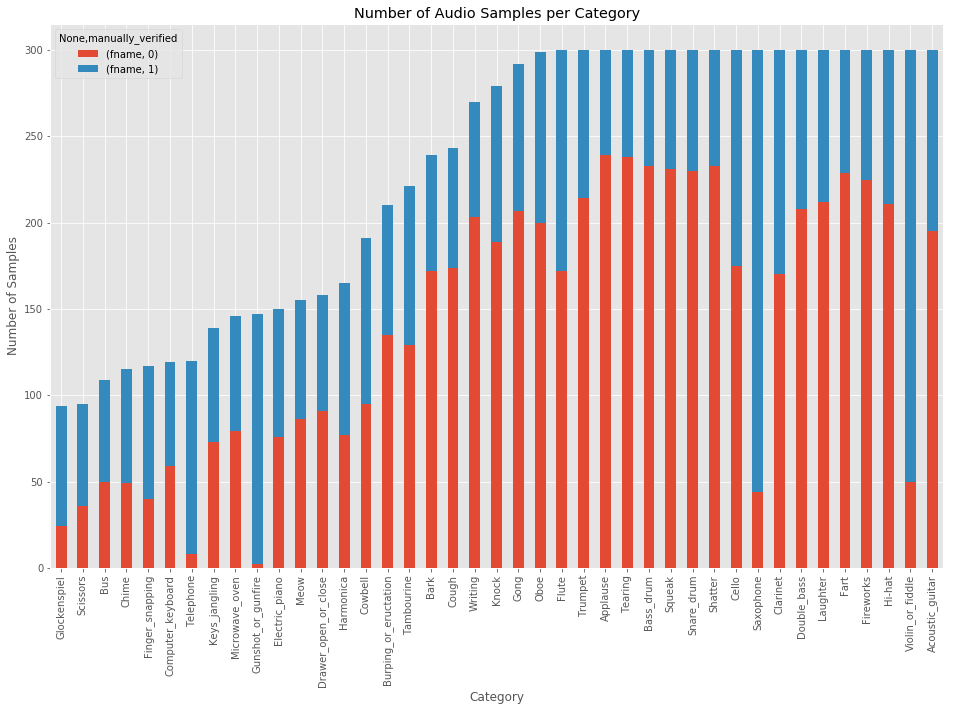

In [5]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

Total samples (frames) =  (224000,)
[ 1.6797570e-04 -2.0134998e-05 -7.2674861e-04 ... -4.2972777e-05
 -4.2764965e-05  7.4707823e-06]


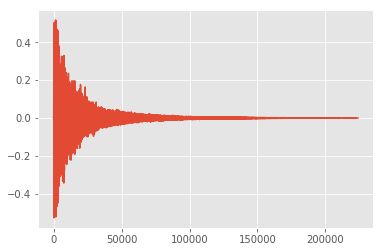

In [6]:
fname = "../../Datasets/freesound-audio-tagging/audio_train/" + "00044347.wav"   # Hi-hat
data, _ = librosa.core.load(fname, sr=SAMPLE_RATE, res_type='kaiser_fast')
print("Total samples (frames) = ", data.shape)
print(data)
IPython.display.display(ipd.Audio(filename=fname))
plt.plot(data, '-', )
plt.show()

Shape:  (40, 63)


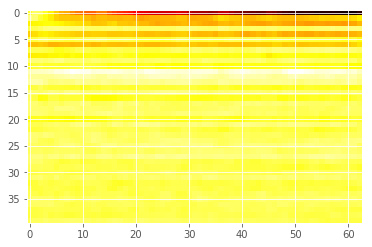

In [7]:
data = data[:2*SAMPLE_RATE]
mfcc = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=40)
print("Shape: ", mfcc.shape)
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

# GAN Architecture

### Discriminator

In [8]:
d = discriminator(AUDIO_SHAPE)
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 64000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9129, 32)          3232      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 9129, 32)          0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 2282, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2282, 32)          128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2282, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 447, 16)           25616     
__________

### Generator

In [9]:
g = generator(NOISE_DIM, AUDIO_SHAPE)
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              501000    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1000)              4000      
_________________________________________________________________
reshape_2 (Reshape)          (None, 1000, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 16)          336       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1000, 16)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000, 16)          64        
__________

### Stacked Generator and Discriminator

In [10]:
s = stacked_G_D(g,d)
s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64000)             1030744   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1193497   
Total params: 2,224,241
Trainable params: 2,219,857
Non-trainable params: 4,384
_________________________________________________________________


### Autoencoder

In [11]:
e = encoder(AUDIO_SHAPE, ENCODE_SIZE)
a = autoEncoder(e, g)
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 500)               2424780   
_________________________________________________________________
sequential_2 (Sequential)    (None, 64000)             1030744   
Total params: 3,455,524
Trainable params: 3,453,188
Non-trainable params: 2,336
_________________________________________________________________


# Audio GAN 

In [12]:
myGan = AudioGAN(label = LABEL)

Data Loaded...
Data Normalized...


### Running Autoencoder

In [13]:
start = time.time()
myGan.train_autoencoder(epochs = 10, save_internal = 2, batch = 32)
end = time.time()
total = round(end - start, 2)
print("\nExecution Time: ", total, "s")

Epoch:  0 , Loss:  [1.9691961, 0.0]
Epoch:  2 , Loss:  [2.902876, 0.0]
Epoch:  4 , Loss:  [1.7192335, 0.0]
Epoch:  6 , Loss:  [1.3745021, 0.0]
Epoch:  8 , Loss:  [1.9085882, 0.0]

Execution Time:  46.28 s


Original:


Result:


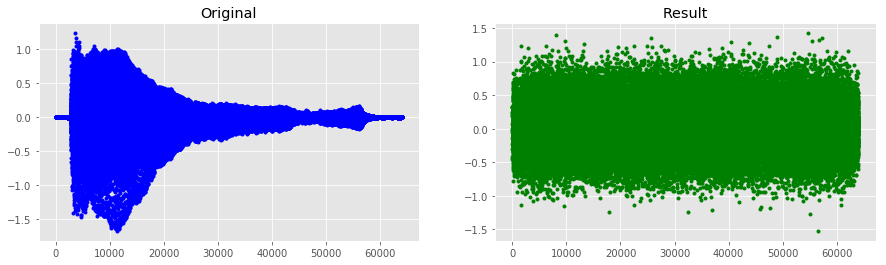

In [14]:
INDEX = 11
sample = myGan.trainData[INDEX]

print("Original:")
IPython.display.display(ipd.Audio(data = sample, rate = SAMPLE_RATE))
librosa.output.write_wav(AUTO_ENCODER_PATH + "AE_Original_" + LABEL + ".wav", 
                         y = sample, sr = SAMPLE_RATE , norm = True)
result = myGan.autoencoder.predict(sample.reshape((1,AUDIO_SHAPE))).flatten()

print("Result:")
IPython.display.display(ipd.Audio(data = result, rate = SAMPLE_RATE))
librosa.output.write_wav(AUTO_ENCODER_PATH + "AE_Result_" + LABEL + ".wav", 
                         y = result, sr = SAMPLE_RATE , norm = True)

fig      = plt.figure(figsize=(1, 2))
Original = fig.add_subplot(1, 2, 1)
Result   = fig.add_subplot(1, 2, 2)

Original.set_title('Original')
Result.set_title('Result')

Original.plot(sample, '.', color ='blue')
Result.plot(result, '.', color ='green')

plt.gcf().set_size_inches(15, 4)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

fig.savefig(PICTURE_PATH + "AE_Compare_" + LABEL + ".png", bbox_inches = "tight")

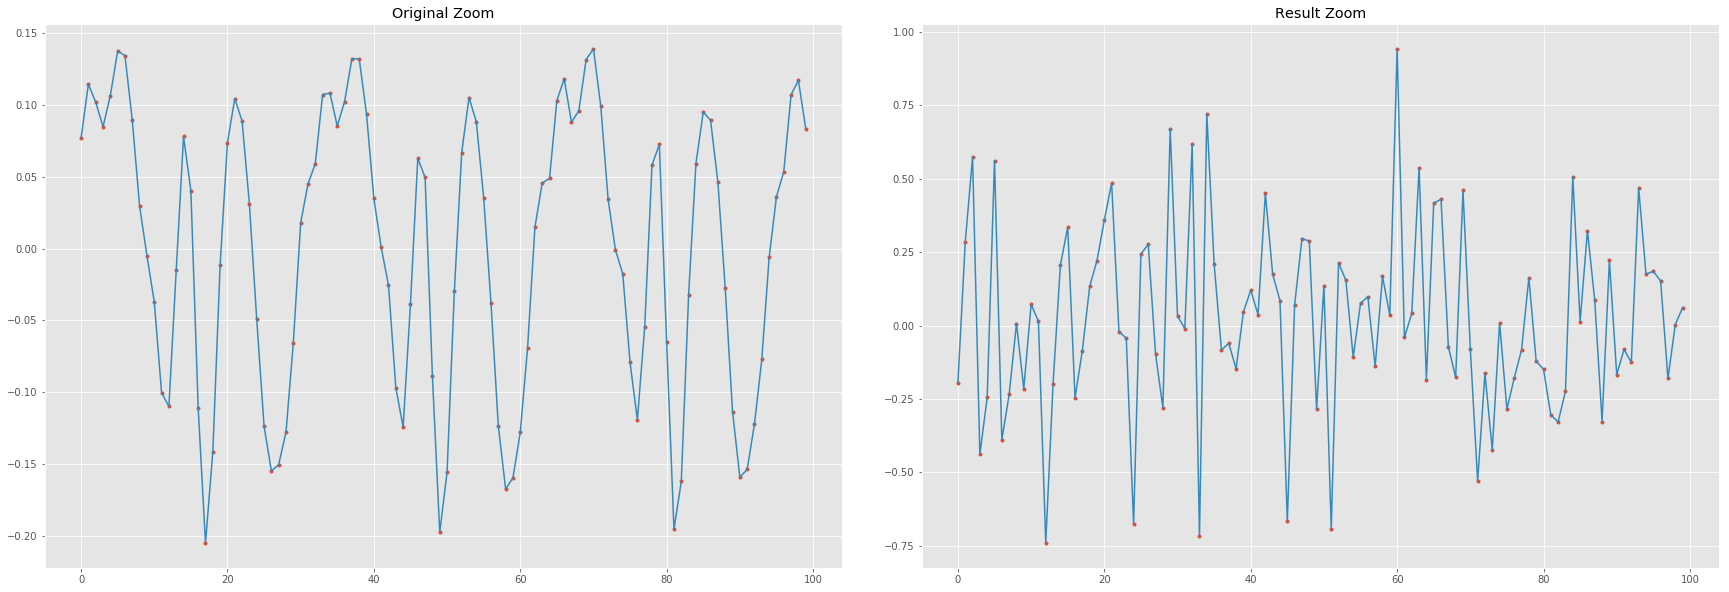

In [15]:
fig      = plt.figure(figsize=(1, 2))
OriginalZ = fig.add_subplot(1, 2, 1)
ResultZ   = fig.add_subplot(1, 2, 2)

OriginalZ.set_title('Original Zoom')
ResultZ.set_title('Result Zoom')

ZoomInit = 40000
ZoomSize = 100

OriginalZ.plot(sample[ZoomInit:ZoomInit+ZoomSize], '.')
OriginalZ.plot(sample[ZoomInit:ZoomInit+ZoomSize], '-')
ResultZ.plot(result[ZoomInit:ZoomInit+ZoomSize], '.')                
ResultZ.plot(result[ZoomInit:ZoomInit+ZoomSize], '-')

plt.gcf().set_size_inches(30, 10)
plt.subplots_adjust(wspace=0.1,hspace=0.3)
plt.show()

fig.savefig(PICTURE_PATH + "AE_CompareZ_" + LABEL + ".png", bbox_inches = "tight")

### Running GAN

epoch: 0
Discriminator_loss: 0.650530, Generator_loss: 0.645716


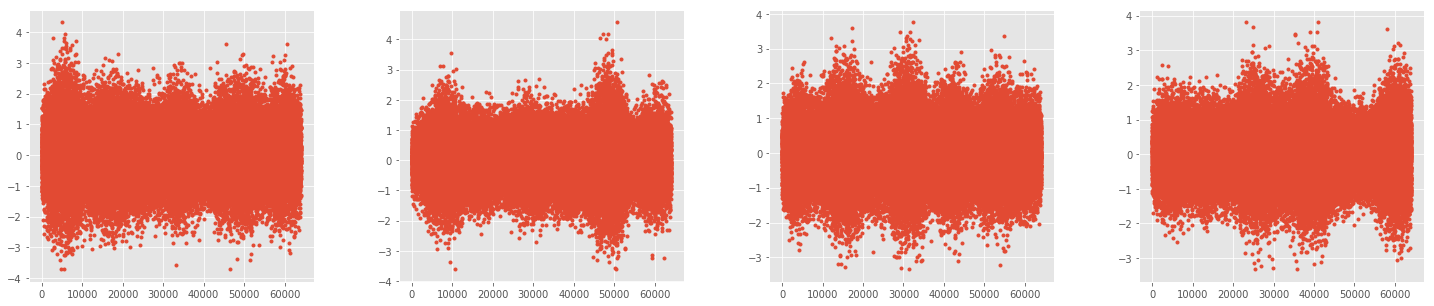

epoch: 1
Discriminator_loss: 0.642987, Generator_loss: 0.711905
epoch: 2
Discriminator_loss: 0.728318, Generator_loss: 0.770587


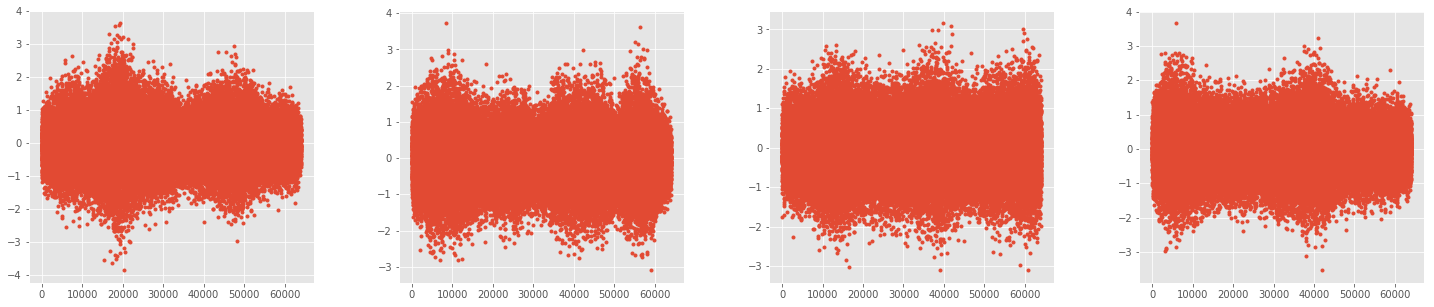

epoch: 3
Discriminator_loss: 0.680507, Generator_loss: 0.635264
epoch: 4
Discriminator_loss: 0.628110, Generator_loss: 0.706719


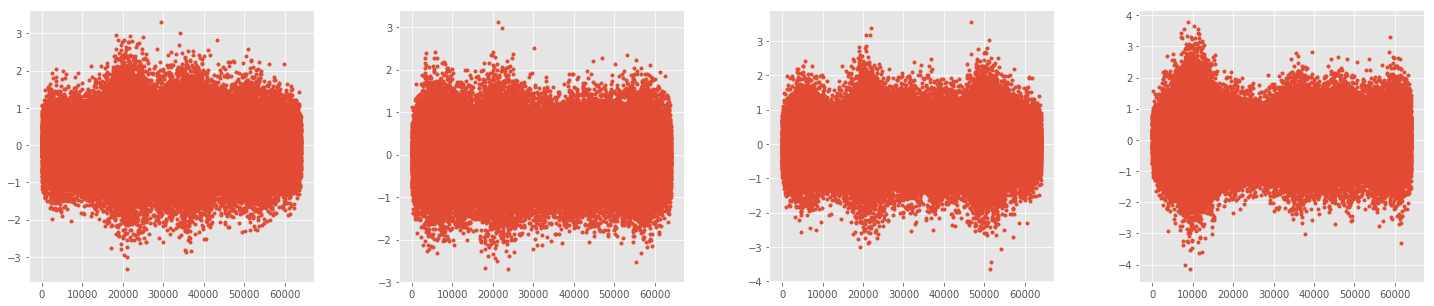

epoch: 5
Discriminator_loss: 0.650837, Generator_loss: 0.670238
epoch: 6
Discriminator_loss: 0.578282, Generator_loss: 0.718988


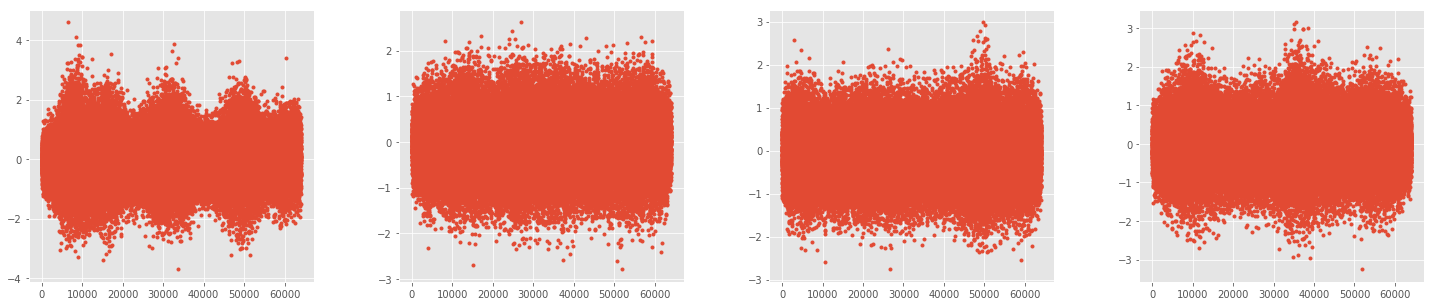

epoch: 7
Discriminator_loss: 0.747052, Generator_loss: 0.736101
epoch: 8
Discriminator_loss: 0.589146, Generator_loss: 0.714251


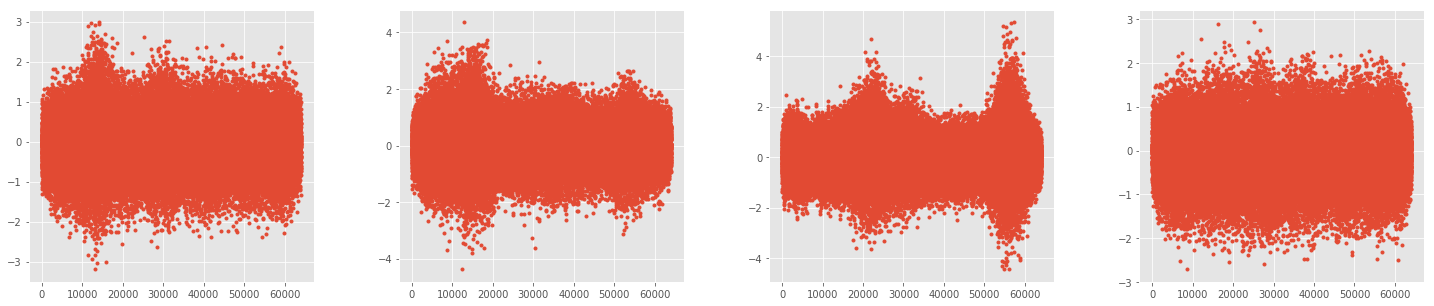

epoch: 9
Discriminator_loss: 0.643268, Generator_loss: 0.713850
Execution Time:  65.56 s


In [16]:
start = time.time()
myGan.train_gan(epochs = 10, batch = 32, save_interval = 2)
end = time.time()
total = round(end - start, 2)
print("Execution Time: ", total, "s")

### Discriminator and Generator Loss over Epochs

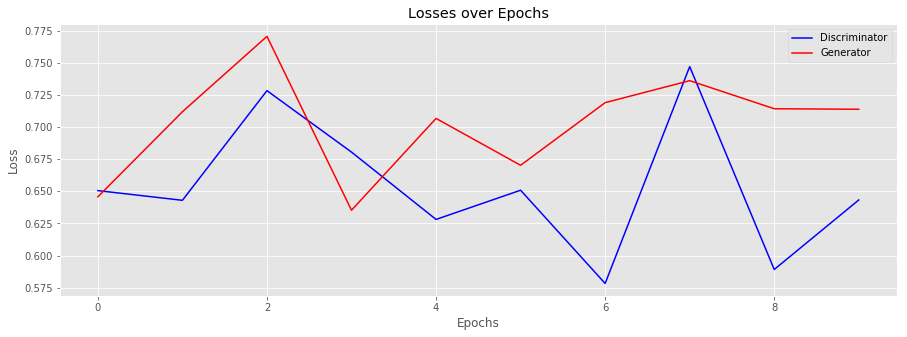

In [17]:
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(myGan.disLossHist, '-', label = 'Discriminator', color = 'blue')
plt.plot(myGan.genLossHist, '-', label = 'Generator',     color = 'red')
plt.legend(loc = 'best')

plt.gcf().set_size_inches(15, 5)
plt.savefig(PICTURE_PATH + "D_G_Loss.png", bbox_inches='tight')
plt.show()

### Test Sample

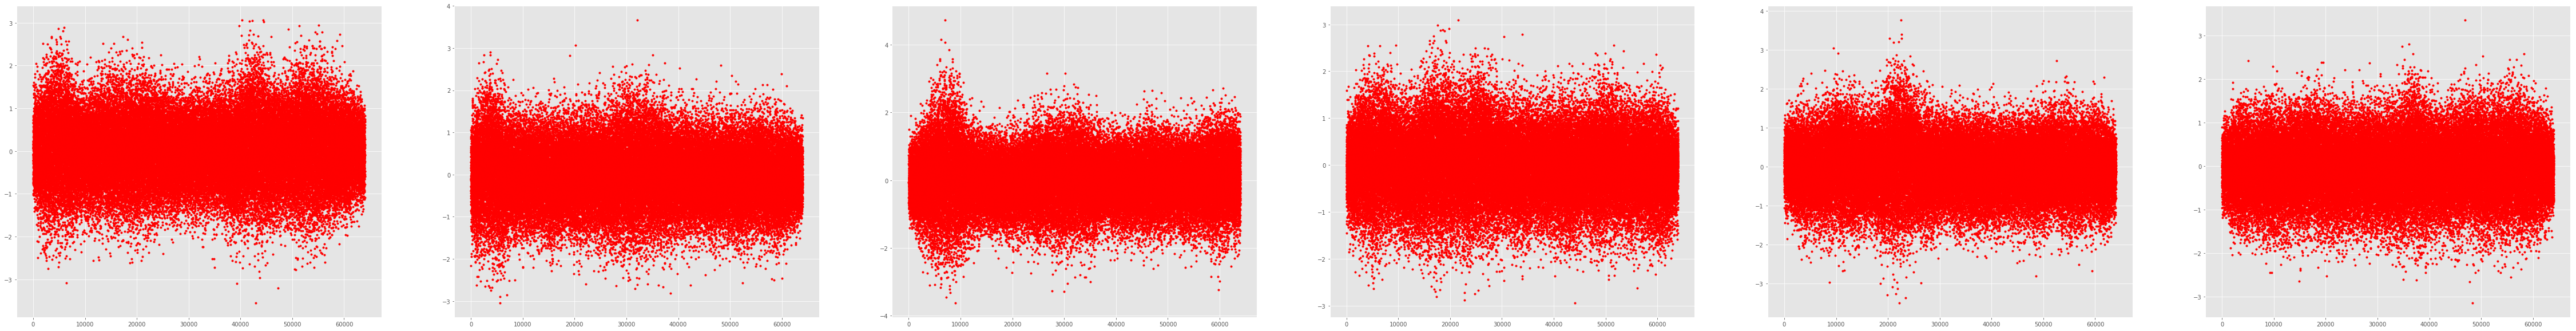

In [18]:
lin, col = 1, 6
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
        
        
for i in range(lin):
    for j in range(col):
        gen_noise = np.random.normal(0, 1, (1,NOISE_DIM))
        gen_test = myGan.gen.predict(gen_noise).flatten()
        #IPython.display.display(ipd.Audio(data=gen_test, rate=SAMPLE_RATE))
        subPlotS[(i*col)+j].plot(gen_test, '.', color='red')



plt.gcf().set_size_inches(80, 10)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

fig.savefig(PICTURE_PATH + "Generated_"+ LABEL + ".png", bbox_inches='tight')

### Original Samples

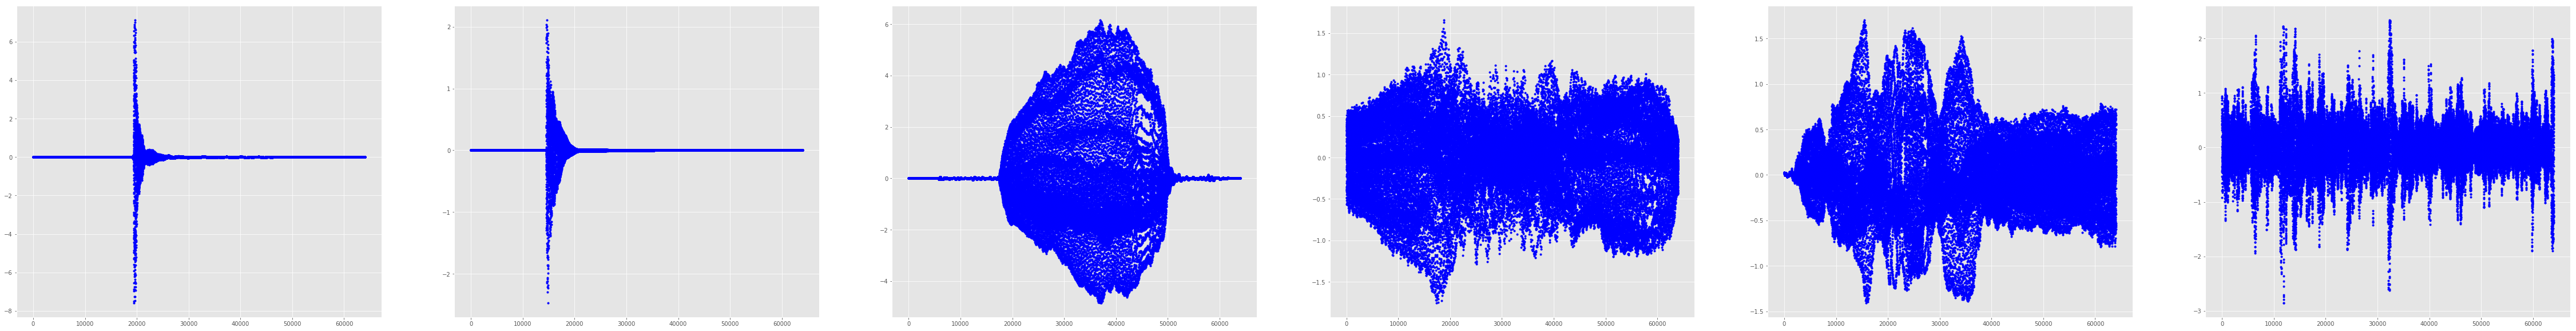

In [19]:
lin, col = 1, 6
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
        
        
for i in range(lin):
    for j in range(col):
        random_index = np.random.randint(0, len(myGan.trainData))
        original = myGan.trainData[random_index]
        #IPython.display.display(ipd.Audio(data=original, rate=SAMPLE_RATE))
        subPlotS[(i*col)+j].plot(original, '.', color='blue')

plt.gcf().set_size_inches(80, 10)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

fig.savefig(PICTURE_PATH + "Originals_"+ LABEL + ".png", bbox_inches='tight')

### Visualize Conv 1D Filters

#### Discriminator

Filters:  32
Kernel Size:  100
(32, 1, 100)


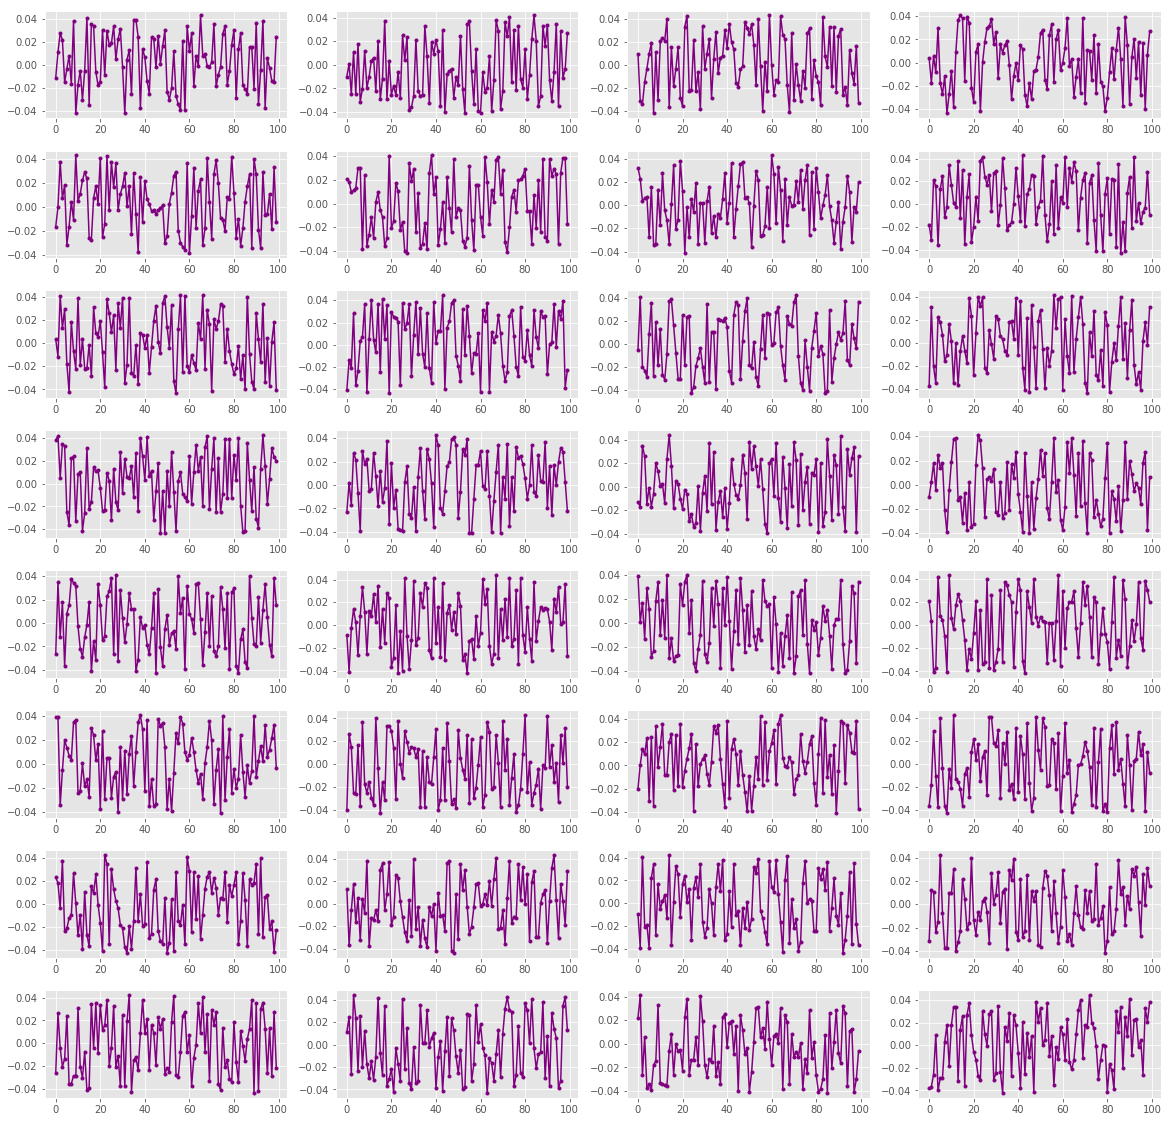

In [25]:
# Obs: lin x col = filters
lin, col = 8, 4

kernelSize = len(myGan.dis.layers[1].get_weights()[0])
filters    = len(myGan.dis.layers[1].get_weights()[0][0][0])

print("Filters: ", filters)
print("Kernel Size: ", kernelSize)

W = myGan.dis.layers[1].get_weights()[0].reshape(filters,1,kernelSize)

print(W.shape)
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
        
layNum = 1     
for i in range(lin):
    for j in range(col):
        convFilter = W[(i*col)+j][0]
        subPlotS[(i*col)+j].plot(convFilter, '.-', color='purple')

plt.gcf().set_size_inches(20, 20)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

#### Generator

Filters:  16
Kernel Size:  20
(16, 1, 20)


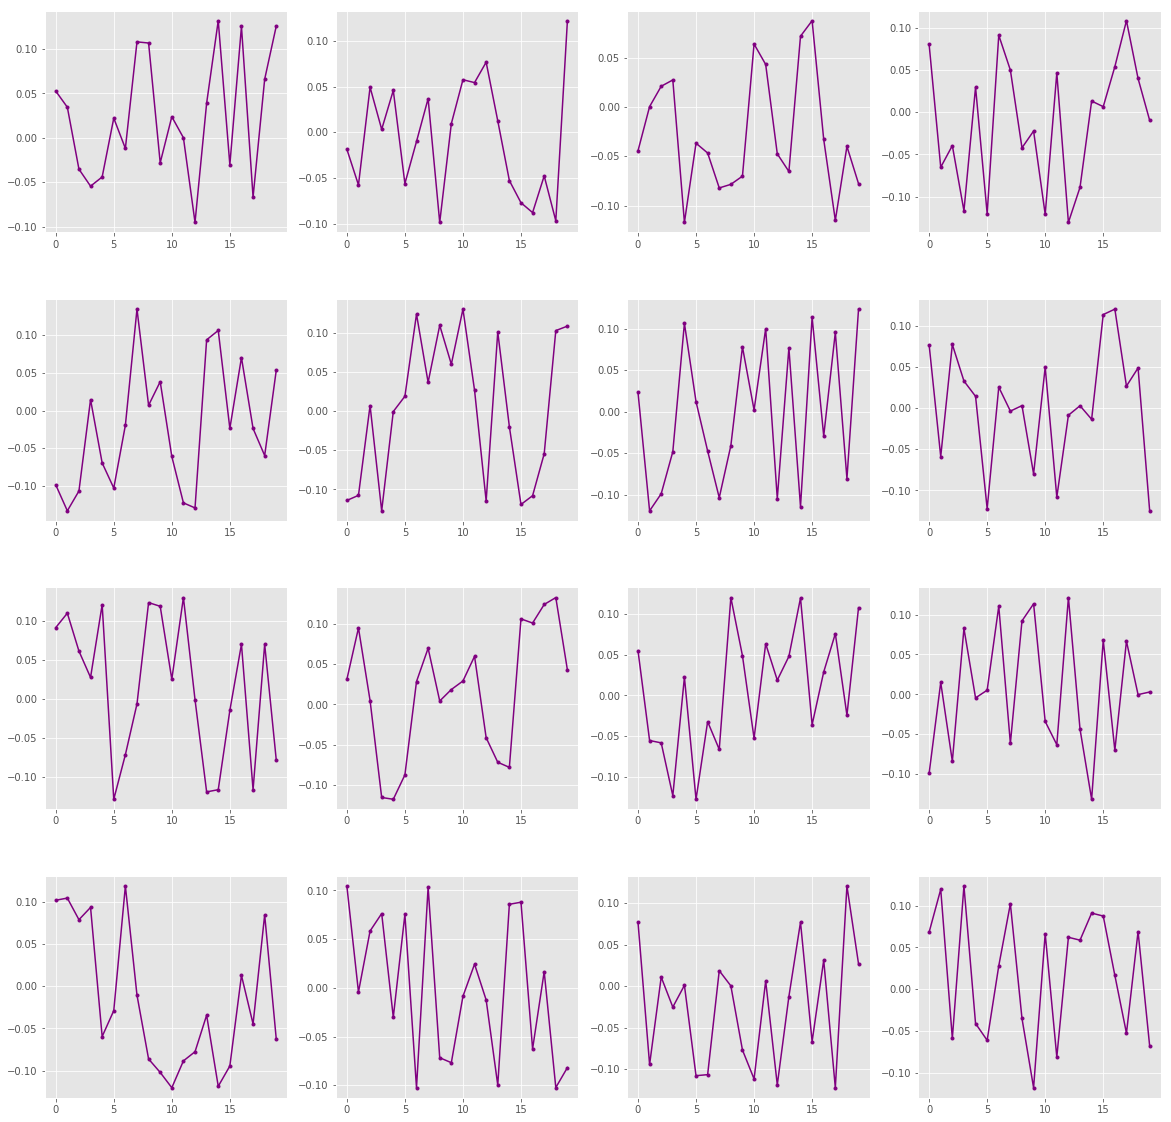

In [27]:
# Obs: lin x col = filters
lin, col = 4, 4

kernelSize = len(myGan.gen.layers[4].get_weights()[0])
filters    = len(myGan.gen.layers[4].get_weights()[0][0][0])

print("Filters: ", filters)
print("Kernel Size: ", kernelSize)

W = myGan.gen.layers[4].get_weights()[0].reshape(filters,1,kernelSize)

print(W.shape)
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
        
layNum = 1     
for i in range(lin):
    for j in range(col):
        convFilter = W[(i*col)+j][0]
        subPlotS[(i*col)+j].plot(convFilter, '.-', color='purple')

plt.gcf().set_size_inches(20, 20)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()